In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7
%matplotlib inline
import gc

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")
from operator import itemgetter

# Load bases

In [2]:
train_df = pd.read_csv('C:/Users/38063/Desktop/Loan_prediction/train.csv')
test_df = pd.read_csv('C:/Users/38063/Desktop/Loan_prediction/test.csv')
[print(df.shape) for df in [train_df,test_df]]

(7500, 18)
(2500, 17)


[None, None]

In [3]:
train_df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
test_df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,7500,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,7501,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,7502,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,7503,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,7504,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5]:
train_df.isnull().sum()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [6]:
test_df.isnull().sum()

Id                                 0
Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [7]:
# 'Annual Income',
# 'Credit Score', - первый и второй - по одни и тем же клиентам пустые значения. Возможно первый входит как предиктор во второй

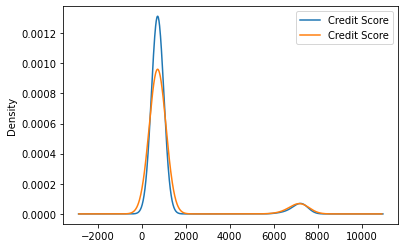

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

for df in [train_df, test_df]:
    df['Credit Score'].plot(kind='kde')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

# Preprocesing

## fill NAN

In [9]:
for df in [train_df, test_df]:
    for f in ['Annual Income', 
              'Months since last delinquent',
              'Bankruptcies',
              ]:
        nf_ = f + '_flNull'
        df[nf_] = np.where(df[f].isnull(), 1, 0)
        print(nf_, df[nf_].isnull().sum())

Annual Income_flNull 0
Months since last delinquent_flNull 0
Bankruptcies_flNull 0
Annual Income_flNull 0
Months since last delinquent_flNull 0
Bankruptcies_flNull 0


In [10]:
# Annual Income
for df in [train_df,test_df]:
    for f in ['Annual Income']:
        mean_ = df['Annual Income'].mean()
        df[f]= df[f].fillna(mean_)

In [11]:
for df in [train_df,test_df]:
    for f in ['Years in current job']:
        nf_ = f#+'_NAN_0'
        df[nf_] = df[f].fillna('0 years')
#         print(df[nf_].isnull().sum())

for df in [train_df,test_df]:
    for f in ['Months since last delinquent']:
        nf_ = f#+'_NAN_0'
        df[nf_] = df[f].fillna(0.0)
#         print(df[nf_].isnull().sum())

In [12]:
for df in [train_df,test_df]:
    for f in ['Bankruptcies']:
        nf_ = f#+'_NAN_0'
        df[nf_] = df[f].fillna(0.0)
#         print(df[nf_].isnull().sum())

In [13]:
gc.collect()

130

In [14]:
predictors = list(set(train_df.columns.tolist()) - set(['Id','Credit Default']))
target = 'Credit Default'
print(len(predictors))

19


In [15]:
obj = train_df[predictors].select_dtypes(include = 'O').columns.tolist()
num = list(set(predictors)-set(obj))
print ('obj = ', len(obj))
print ('num = ', len(num))

obj =  4
num =  15


In [16]:
bin_pred =[f for f in list(set(predictors)) if train_df[f].nunique(dropna=False)<=2]
len(bin_pred)

4

In [17]:
num = list(set(num)-set(bin_pred))
obj = list(set(obj)-set(bin_pred))
print ('num = ', len(num))
print ('obj = ', len(obj))

num =  12
obj =  3


In [18]:
bin_pred

['Annual Income_flNull',
 'Months since last delinquent_flNull',
 'Bankruptcies_flNull',
 'Term']

In [19]:
obj

['Purpose', 'Home Ownership', 'Years in current job']

In [20]:
num

['Credit Score',
 'Bankruptcies',
 'Monthly Debt',
 'Tax Liens',
 'Years of Credit History',
 'Current Loan Amount',
 'Current Credit Balance',
 'Number of Credit Problems',
 'Number of Open Accounts',
 'Annual Income',
 'Months since last delinquent',
 'Maximum Open Credit']

In [21]:
num_pred = num.copy()
obj_pred = obj.copy()

In [22]:
for i in predictors:
    if i not in bin_pred+num_pred+obj_pred:
        print (i)

# Correlation check

In [23]:
train_df.corr()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_flNull,Months since last delinquent_flNull,Bankruptcies_flNull
Id,1.000000,1.015464e-02,0.003393,0.004145,-0.009556,-0.022672,0.008264,0.011222,0.003357,-0.008485,-0.015758,0.005590,0.036498,0.012858,-1.401903e-02,-0.010536,-0.012201
Annual Income,0.010155,1.000000e+00,0.058466,0.167589,0.166076,0.021275,-0.013705,0.005662,-0.059775,0.031525,0.347631,0.518798,-0.037832,-0.088697,-1.111530e-16,-0.061541,-0.035827
Tax Liens,0.003393,5.846638e-02,1.000000,-0.005360,0.009109,-0.002410,0.595339,0.070684,0.057423,-0.007835,-0.010195,0.027211,0.010581,0.024368,6.151984e-03,-0.053204,-0.004798
Number of Open Accounts,0.004145,1.675893e-01,-0.005360,1.000000,0.144819,0.023897,-0.017813,0.033982,-0.018859,0.001346,0.267325,0.413904,0.016095,0.028884,2.152277e-03,-0.062793,-0.016886
Years of Credit History,-0.009556,1.660758e-01,0.009109,0.144819,1.000000,0.029247,0.071259,0.097312,0.085592,0.010623,0.217856,0.191978,-0.015683,-0.020567,1.400793e-03,-0.136283,0.001165
Maximum Open Credit,-0.022672,2.127477e-02,-0.002410,0.023897,0.029247,1.000000,-0.004750,-0.010358,-0.011632,-0.002334,0.088090,0.010197,-0.009136,-0.014275,1.737356e-02,0.012672,-0.001117
Number of Credit Problems,0.008264,-1.370497e-02,0.595339,-0.017813,0.071259,-0.004750,1.000000,0.108892,0.730808,-0.008596,-0.124137,-0.042252,-0.018473,0.020088,1.523152e-03,-0.049814,-0.014746
Months since last delinquent,0.011222,5.661689e-03,0.070684,0.033982,0.097312,-0.010358,0.108892,1.000000,0.067634,-0.016163,-0.082444,-0.002832,-0.002758,0.010110,-1.456266e-02,-0.762922,-0.007149
Bankruptcies,0.003357,-5.977484e-02,0.057423,-0.018859,0.085592,-0.011632,0.730808,0.067634,1.000000,-0.006169,-0.142553,-0.078847,-0.027892,0.001640,-4.800303e-03,0.005244,-0.014578
Current Loan Amount,-0.008485,3.152501e-02,-0.007835,0.001346,0.010623,-0.002334,-0.008596,-0.016163,-0.006169,1.000000,0.016672,-0.009382,-0.108552,-0.226522,-1.855448e-01,0.021441,0.013160


<AxesSubplot:>

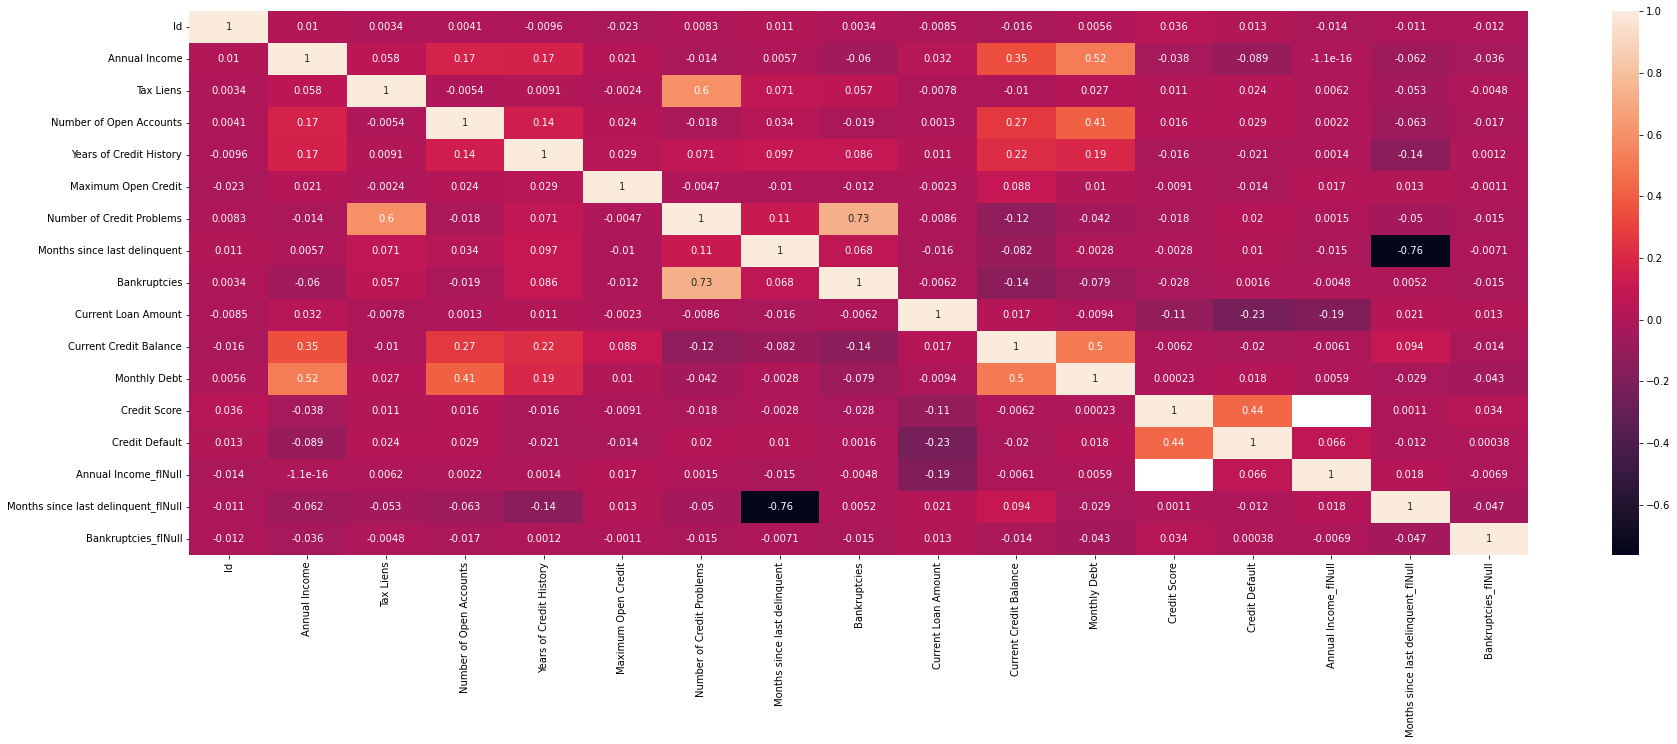

In [24]:
plt.figure(figsize=(30,10))
sns.heatmap(train_df.corr(),annot=True,fmt=".2g")

In [25]:
print(len(num_pred))
num_pred.remove('Months since last delinquent')
bin_pred.remove('Term')
print(len(num_pred))

12
11


# LogisticRegression

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df[target], test_size=0.2, random_state=42)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.model_selection import cross_validate

class PassthroughTransformer:
    def __init__(self):
        pass
    def fit(self,X,y=None):
        if isinstance(X,pd.DataFrame):
            self.colnames = X.columns.tolist()
        else:
            self.colnames = [str(col) for col in np.arange(0,X.shape[0])]
        return self
    def transform(self,X):
        return X
    def get_feature_names(self):
        return self.colnames

In [28]:
obj_lg_pipe_woe = Pipeline([('woe', ce.WOEEncoder(handle_unknown='value'))])
tr_standart_zero=Pipeline([('imp', SimpleImputer(fill_value=0, strategy='constant'))])
tr_passthrough= Pipeline([('transf',PassthroughTransformer())])  
    
transformers_f = [('obj_lg_pipe_woe',         obj_lg_pipe_woe,           obj_pred),  
                  ('tr_standart_zero',        tr_standart_zero,          num_pred), 
                  ('tr_passthrough',          tr_passthrough,            bin_pred)
                 ] 

al_pipe_feats = obj_pred+num_pred+bin_pred
                
print (len(al_pipe_feats), len(set(al_pipe_feats)))
transformer_com = ColumnTransformer (transformers=transformers_f)
COM_pipe = Pipeline([('transf', transformer_com),
                     ('scaler',MinMaxScaler()),
                     ('lg', LogisticRegression(n_jobs=-1))])

17 17


In [29]:
tscv = TimeSeriesSplit(n_splits=3) 

In [30]:
cv_scres = cross_validate(COM_pipe,
                          X_train[al_pipe_feats].reset_index(drop=True),
                          y_train.reset_index(drop=True),
                          return_train_score=True,
                          verbose=3,
                          cv=tscv,
                          n_jobs=3,
                          scoring = 'f1')
print (cv_scres['train_score'])
print (cv_scres['test_score'])
COM_pipe.fit(X_train[al_pipe_feats].reset_index(drop=True),y_train.reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe.predict(X_test[al_pipe_feats])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[0.3254902  0.3234127  0.32806324]
[0.32677165 0.33201581 0.30612245]
Train 0.3290386521308226
Test 0.33707865168539325


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished


In [31]:
from sklearn.pipeline import  Pipeline
from hyperopt import hp, tpe, fmin, STATUS_OK, space_eval

def hp_tuning (clf_, X, y, space_, folds_, scoring_):
    def hyp_objective(params):
        clf_.set_params(**params)

        score = cross_validate(clf_, X, y, cv=folds_, 
                               scoring = scoring_,n_jobs =12, return_train_score=True)

        train_score = score['train_score']
        test_score  = score['test_score']
        ovf = (train_score.mean()-test_score.mean())

        it_score =  test_score.mean() - (ovf + test_score.std())
        print (train_score)
        print (test_score)
        return it_score

    def f(params):
        acc = hyp_objective(params)
        print (acc, params)
        return {'loss': -acc, 'status': STATUS_OK}

    best = fmin(fn=f,
                space=space_,
                algo=tpe.suggest,
                rstate = np.random.default_rng(4),
                max_evals=50)
    return best

In [32]:
space_hyp = {
             'lg__C': hp.quniform('lg__C', 0.001, 1.0, 0.001),
             'lg__solver':  hp.choice('lg__solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
             'lg__class_weight':  hp.choice('lg__class_weight', ['balanced', None]),
                } 
best = hp_tuning (COM_pipe,
                  X_train[al_pipe_feats], y_train, 
                  space_hyp, tscv, 'f1')

[0.50146915 0.50294118 0.51308562]                                                                                     
[0.4729064  0.49950642 0.49353234]                                                                                     
0.4600694724364739                                                                                                     
{'lg__C': 0.626, 'lg__class_weight': 'balanced', 'lg__solver': 'liblinear'}                                            
[0.50246305 0.5036964  0.51298701]                                                                                     
[0.46580773 0.50499002 0.49249249]                                                                                     
0.4528027814123923                                                                                                     
{'lg__C': 0.666, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs'}                                                
[0.32142857 0.32135729 0.32625995]      

In [33]:
print (f'Selected params  - ', space_eval(space_hyp, best))

Selected params  -  {'lg__C': 0.419, 'lg__class_weight': 'balanced', 'lg__solver': 'liblinear'}


In [34]:
gc.collect()

127

In [35]:
obj_lg_pipe_woe = Pipeline([('woe', ce.WOEEncoder(handle_unknown='value'))])
tr_standart_zero=Pipeline([('imp', SimpleImputer(fill_value=0, strategy='constant'))])
tr_passthrough= Pipeline([('transf',PassthroughTransformer())])  
    
transformers_f = [('obj_lg_pipe_woe',         obj_lg_pipe_woe,           obj_pred),  
                  ('tr_standart_zero',        tr_standart_zero,          num_pred), 
                  ('tr_passthrough',          tr_passthrough,            bin_pred)
                 ] 

al_pipe_feats = obj_pred+num_pred+bin_pred
                
print (len(al_pipe_feats), len(set(al_pipe_feats)))
transformer_com = ColumnTransformer (transformers=transformers_f)
COM_pipe = Pipeline([('transf', transformer_com),
                     ('scaler',MinMaxScaler()),
                     ('lg', LogisticRegression(C = 0.419, class_weight = 'balanced', solver= 'liblinear'))])

17 17


In [36]:
cv_scres = cross_validate(COM_pipe,
                          X_train[al_pipe_feats].reset_index(drop=True),
                          y_train.reset_index(drop=True),
                          return_train_score=True,
                          verbose=3,
                          cv=tscv,
                          n_jobs=3,
                          scoring = 'f1')
print (cv_scres['train_score'])
print (cv_scres['test_score'])
COM_pipe.fit(X_train[al_pipe_feats].reset_index(drop=True),y_train.reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe.predict(X_test[al_pipe_feats])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[0.50048497 0.49707031 0.51137102]
[0.48062016 0.49950836 0.48809524]
Train 0.5044031311154598
Test 0.4911955514365153


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


In [37]:
COM_pipe.fit(train_df[al_pipe_feats].reset_index(drop=True),train_df[target].reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe.predict(X_test[al_pipe_feats])))
print ('All', f1_score(train_df[target],COM_pipe.predict(train_df[al_pipe_feats])))

Train 0.5040924410207029
Test 0.4917127071823204
All 0.5015267175572519


# RandomForestClassifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
COM_pipe_RFC = Pipeline([('transf', transformer_com),
                     ('scaler',MinMaxScaler()),
                     ('RFC', RandomForestClassifier())])

In [40]:
cv_scres = cross_validate(COM_pipe_RFC,
                          X_train[al_pipe_feats].reset_index(drop=True),
                          y_train.reset_index(drop=True),
                          return_train_score=True,
                          verbose=3,
                          cv=tscv,
                          n_jobs=3,
                          scoring = 'f1')
print (cv_scres['train_score'])
print (cv_scres['test_score'])
COM_pipe_RFC.fit(X_train[al_pipe_feats].reset_index(drop=True),y_train.reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe_RFC.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe_RFC.predict(X_test[al_pipe_feats])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s finished


[1. 1. 1.]
[0.40282686 0.40143369 0.38198198]
Train 1.0
Test 0.4087837837837837


In [41]:
gc.collect()

266

# DecisionTreeClassifier

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
COM_pipe_DTC = Pipeline([('transf', transformer_com),
                     ('scaler',MinMaxScaler()),
                     ('DTC', DecisionTreeClassifier())])

In [44]:
cv_scres = cross_validate(COM_pipe_DTC,
                          X_train[al_pipe_feats].reset_index(drop=True),
                          y_train.reset_index(drop=True),
                          return_train_score=True,
                          verbose=3,
                          cv=tscv,
                          n_jobs=3,
                          scoring = 'f1')
print (cv_scres['train_score'])
print (cv_scres['test_score'])
COM_pipe_DTC.fit(X_train[al_pipe_feats].reset_index(drop=True),y_train.reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe_DTC.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe_DTC.predict(X_test[al_pipe_feats])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished


[1. 1. 1.]
[0.45211581 0.46046512 0.46916566]
Train 1.0
Test 0.4543429844097996


In [45]:
COM_pipe_DTC.fit(train_df[al_pipe_feats].reset_index(drop=True),train_df[target].reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe_DTC.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe_DTC.predict(X_test[al_pipe_feats])))
print ('All', f1_score(train_df[target],COM_pipe_DTC.predict(train_df[al_pipe_feats])))

Train 1.0
Test 1.0
All 1.0


In [46]:
gc.collect()

194

# C-Support Vector Classification

In [47]:
from sklearn.svm import SVC

In [48]:
COM_pipe_SVC = Pipeline([('transf', transformer_com),
                     ('scaler',MinMaxScaler()),
                     ('SVC', SVC(gamma='scale'))])

In [49]:
cv_scres = cross_validate(COM_pipe_SVC,
                          X_train[al_pipe_feats].reset_index(drop=True),
                          y_train.reset_index(drop=True),
                          return_train_score=True,
                          verbose=3,
                          cv=tscv,
                          n_jobs=3,
                          scoring = 'f1')
print (cv_scres['train_score'])
print (cv_scres['test_score'])
COM_pipe_SVC.fit(X_train[al_pipe_feats].reset_index(drop=True),y_train.reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe_SVC.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe_SVC.predict(X_test[al_pipe_feats])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


[0.31474104 0.31863727 0.32356858]
[0.32258065 0.32669323 0.30041152]
Train 0.32264529058116237
Test 0.32892249527410206


In [50]:
space_hyp = {
             'SVC__C': hp.quniform('SVC__C', 0.001, 1.0, 0.001),
             'SVC__kernel':  hp.choice('SVC__kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']),
             'SVC__gamma':  hp.choice('SVC__gamma', ['scale', 'float']),
                } 
best = hp_tuning (COM_pipe_SVC,
                  X_train[al_pipe_feats], y_train, 
                  space_hyp, tscv, 'f1')

[0.31474104 0.31863727 0.32133333]                                                                                     
[0.32258065 0.32669323 0.30041152]                                                                                     
0.30334365311694617                                                                                                    
{'SVC__C': 0.626, 'SVC__gamma': 'scale', 'SVC__kernel': 'rbf'}                                                         
[0.32475248 0.32367632 0.32536521]                                                                                     
[0.3253012  0.33267327 0.30327869]                                                                                     
0.303750201851473                                                                                                      
{'SVC__C': 0.666, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly'}                                                        
[nan nan nan]                           

In [51]:
print (f'Selected params  - ', space_eval(space_hyp, best))

Selected params  -  {'SVC__C': 0.666, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly'}


In [52]:
COM_pipe_SVC = Pipeline([('transf', transformer_com),
                     ('scaler',MinMaxScaler()),
                     ('SVC', SVC(C = 0.666, gamma='scale', kernel = 'poly'))])

In [53]:
cv_scres = cross_validate(COM_pipe_SVC,
                          X_train[al_pipe_feats].reset_index(drop=True),
                          y_train.reset_index(drop=True),
                          return_train_score=True,
                          verbose=3,
                          cv=tscv,
                          n_jobs=3,
                          scoring = 'f1')
print (cv_scres['train_score'])
print (cv_scres['test_score'])
COM_pipe_SVC.fit(X_train[al_pipe_feats].reset_index(drop=True),y_train.reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe_SVC.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe_SVC.predict(X_test[al_pipe_feats])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished


[0.32475248 0.32367632 0.32536521]
[0.3253012  0.33267327 0.30327869]
Train 0.32248372558838256
Test 0.32892249527410206


In [54]:
COM_pipe_SVC.fit(train_df[al_pipe_feats].reset_index(drop=True),train_df[target].reset_index(drop=True))
print ('Train', f1_score(y_train,COM_pipe_SVC.predict(X_train[al_pipe_feats])))
print ('Test', f1_score(y_test,COM_pipe_SVC.predict(X_test[al_pipe_feats])))
print ('All', f1_score(train_df[target],COM_pipe_SVC.predict(train_df[al_pipe_feats])))

Train 0.3218045112781954
Test 0.33207547169811324
All 0.32396039603960397
